## Testing Articulos-v2

In [2]:
%load_ext autoreload
%autoreload 2
import json

with open("../../dumps/coronavirus-argentina-v2.json") as f:
    arts = json.load(f)
    
with open("../../dumps/coronavirus-argentina-v1.1.json") as f:
    old_arts = json.load(f)

In [3]:
len(arts), len(old_arts)

(55110, 34021)

In [4]:
arts[0].keys()

dict_keys(['_id', 'tweet_id', 'text', 'slug', 'title', 'url', 'user', 'body', 'created_at', 'comments'])

/home/jmperez/.local/share/virtualenvs/hatespeech-collection-qaK7Gomm/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


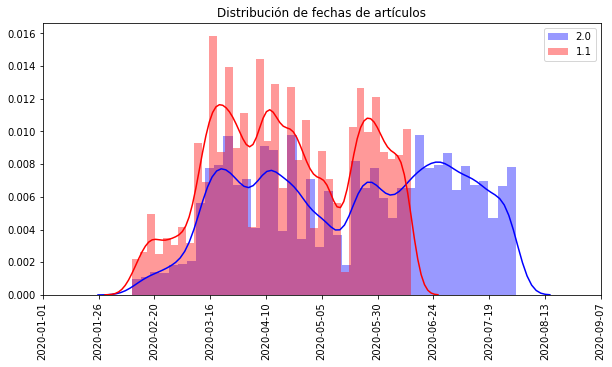

In [5]:
from hate_collector.plot import distplot_dates
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))

distplot_dates([d["created_at"]["$date"] for d in arts], color="blue", label="2.0")
distplot_dates([d["created_at"]["$date"] for d in old_arts], color="red", label="1.1")
plt.legend()

plt.title("Distribución de fechas de artículos");
plt.savefig("distribucion_fechas_2.0.png")

Casi dos meses más de datos

Fecha mínima: 10 de Febrero de 2020

Fecha máxima: 29 de Julio   de 2020


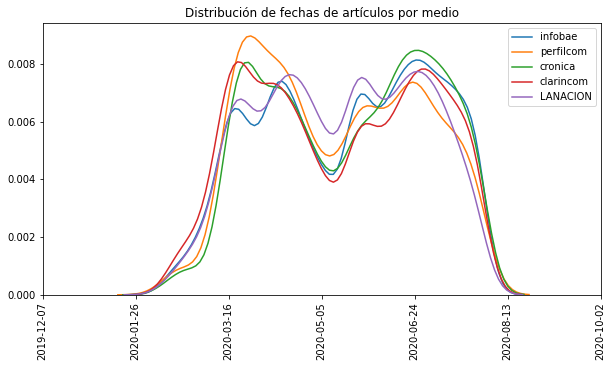

In [6]:
from collections import defaultdict
import datetime

dates_by_newspaper = defaultdict(list)

for art in arts:
    date = datetime.datetime.strptime(art["created_at"]["$date"], "%Y-%m-%dT%H:%M:%SZ")
    dates_by_newspaper[art["user"]].append(date)
    

plt.figure(figsize=(10, 5))

for newspaper, dates in dates_by_newspaper.items():
    distplot_dates(dates, label=newspaper, hist=False)
    
plt.legend()
plt.title("Distribución de fechas de artículos por medio");

plt.savefig("fechas_por_medios.png")


Hay un problema con `infobae`

In [7]:
dates = [datetime.datetime.strptime(art["created_at"]["$date"], "%Y-%m-%dT%H:%M:%SZ") for art in arts]


min(dates), max(dates)

(datetime.datetime(2020, 2, 10, 0, 0, 39),
 datetime.datetime(2020, 7, 31, 19, 2, 57))

In [8]:
dates = [datetime.datetime.strptime(art["created_at"]["$date"], "%Y-%m-%dT%H:%M:%SZ") for art in old_arts]


min(dates), max(dates)

(datetime.datetime(2020, 2, 10, 0, 0, 8),
 datetime.datetime(2020, 6, 14, 13, 24, 22))

In [9]:
len(arts)

55110

In [10]:
len(old_arts)

34021

In [12]:
from collections import Counter

counter = Counter(art["user"] for art in arts)
old_counter = Counter(art["user"] for art in old_arts)

for k in counter:
    print(f"{k:<10} -- {counter[k]:<}")

infobae    -- 18987
perfilcom  -- 4363
cronica    -- 8392
clarincom  -- 15190
LANACION   -- 8178


In [14]:

for k in old_counter:
    print(f"{k:<10} -- {old_counter[k]:<}")

perfilcom  -- 3114
clarincom  -- 10423
LANACION   -- 6515
infobae    -- 8517
cronica    -- 5452


In [12]:
from datetime import datetime

dates = [datetime.strptime(art["created_at"]["$date"], '%Y-%m-%dT%H:%M:%SZ') for art in arts]

In [13]:
dates[0]

datetime.datetime(2020, 4, 15, 10, 40, 49)

Text(53.875, 0.5, '#artículos')

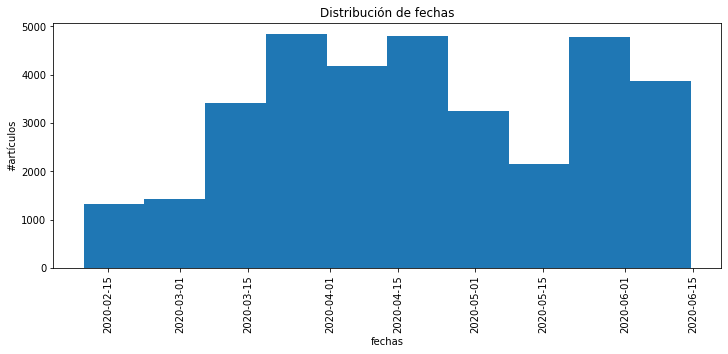

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(dates)
plt.xticks(rotation=90)
plt.title("Distribución de fechas")
plt.xlabel("fechas")

plt.savefig("distr-fechas.png")
plt.tight_layout(pad=1.0)
plt.ylabel("#artículos")

## Artículos que "perdimos"

In [7]:
with open("../../dumps/coronavirus-argentina-v1.json") as f:
    old_arts = json.load(f)

In [12]:
from collections import Counter

old_counter = Counter(art["user"] for art in old_arts)

old_counter - counter

Counter({'perfilcom': 47,
         'clarincom': 199,
         'LANACION': 103,
         'cronica': 67,
         'infobae': 3422})

In [24]:
old_counter

Counter({'perfilcom': 3161,
         'clarincom': 10622,
         'LANACION': 6618,
         'cronica': 5519,
         'infobae': 11939})

Perdimos muchas de infobae! busquemos estas..

In [31]:
infobae_missing_arts = [
    art["tweet_id"] for art in old_arts if art["user"] == "infobae" and art["tweet_id"] not in tw_ids
]

In [32]:
len(infobae_missing_arts)

3441

Vamos a recuperar los datos actualmente en la BBDD porque los viejos datos tienen mal el cuerpo

In [50]:
from mongoengine import connect
from tweepyrate import create_apps
from hatespeech_models import Tweet, Article

client = connect("hatespeech-news")

db = client["hatespeech-news"]

missing_arts = Article.objects(tweet_id__in=infobae_missing_arts).order_by("created_at")

missing_arts.count()

3441

Pongo la conclusión acá (y borro el output): está bien! Sacó muchos artículos basura

In [ ]:
for i, art in enumerate(missing_arts):
    print("="*80)
    print(art.created_at)
    print(f"{i+1} -- {art}")
    
    print(art.body[:200])
